# Importing libraries

In [1]:
import numpy as np
from tqdm import tqdm
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset
import torch.optim as optim

import numpy as np
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt

# width of the print
np.set_printoptions(linewidth=300)

In [2]:
# Simple LSTM Many to One Example on a Logistic Curve with a single feature 
# Data is generated from a logistic curve witn no noise, 
# goal is to make model learn the logistic curve


# Data generation

In [4]:
# Logistic function
def logistic_curve(x, L, k, x0, b):
    return L / (1 + np.exp(-k * (x - x0))) + b

# Generate data
x_train = np.linspace(0, 2500, 2500)  # x-axis points
L, k, x0, b = 1, 0.005, 1250, 1       # Parameters for logistic curve
y_train = logistic_curve(x_train, L, k, x0, b)

In [25]:
# Total data size
data_size = len(y_train)

# Normalize the data
scaler = MinMaxScaler()
y_train_scaled = scaler.fit_transform(y_train.reshape(-1, 1)).flatten()

# Keep 100% of data for training
train_data = y_train_scaled

# Percentage of data to use for val and test
val_percentage = 0.2
test_percentage = 0.1

val_size = int(len(train_data) * val_percentage)
test_size = int(len(train_data) * test_percentage)

print(f"val_size: {val_size}, test_size: {test_size}, train_size: {len(train_data)}")

# Validation set is the last `val_size` points of the training data
val_data = train_data[-(val_size + test_size):-test_size]
test_data = train_data[-test_size:]



val_size: 500, test_size: 250, train_size: 2500


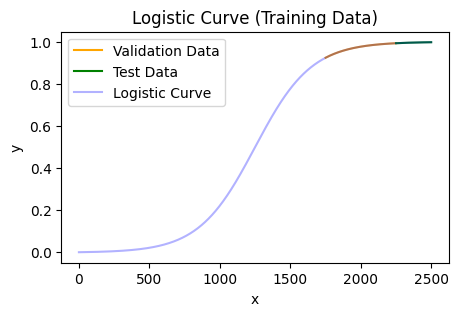

In [41]:
# Plot the curve
plt.figure(figsize=(5, 3))
plt.plot(x_train[-(val_size + test_size):-test_size], val_data, label="Validation Data", color="orange")
plt.plot(x_train[-test_size:], test_data, label="Test Data", color="green")
plt.plot(x_train, y_train_scaled, label="Logistic Curve", color="blue", alpha=0.3)
plt.xlabel("x")
plt.ylabel("y")
plt.title("Logistic Curve (Training Data)")
plt.legend()
plt.show()

# Data preparation pytorch *Dataset* and *DataLoader*

In [42]:

class TimeSeriesDataset(Dataset):
    def __init__(self, data, seq_len):
        """
        Parameters:
        - data: 1D array or list of time series data.
        - seq_len: Length of input sequences.
        """

        self.data = torch.tensor(data, dtype=torch.float32)
        self.seq_len = seq_len

    def __len__(self):
        # Handle edge case where data is too short
        return max(0, len(self.data) - self.seq_len)

    def __getitem__(self, idx):
        """
        Returns:
        - x: Input sequence of shape (seq_len, 1).
        - y: Target value (scalar).
        """
        x = self.data[idx:idx + self.seq_len]  # Input sequence
        y = self.data[idx + self.seq_len]  # Target (next value)
        return x.unsqueeze(-1), y.unsqueeze(-1)  # Add feature dim for LSTM

    def visualize_sample(self, idx):
        """
        Visualizes a single sample from the dataset.
        Prints input sequence and target value.
        """
        x, y = self[idx]
        print(f"Input sequence (x): {x.squeeze().numpy()}")
        print(f"Target (y): {y.item()}")
    
    def plot_sample(self, idx):
        """
        Plots the input sequence and the target value for a single sample.
        """
        x, y = self[idx]
        x = x.squeeze().numpy()  # Remove extra dimensions for plotting
        y = y.item()  # Convert target to scalar

        plt.figure(figsize=(8, 4))
        plt.plot(range(len(x)), x, label="Input Sequence", marker="o")
        # plt.axhline(y, color="red", linestyle="--", label="Target Value")
        plt.scatter(len(x), y, color = "red",  label="Target Value", marker="o")
        plt.xlabel("Time Steps")
        plt.ylabel("Normalized Value")
        plt.title(f"Sample {idx}: Input Sequence and Target")
        plt.legend()
        plt.show()

seq_len = 50

train_dataset = TimeSeriesDataset(y_train_scaled, seq_len)
val_dataset = TimeSeriesDataset(val_data, seq_len)
test_dataset = TimeSeriesDataset(test_data, seq_len)


In [45]:
batch_size = 32

train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

print(f"Training Dataset: {len(train_dataset)} samples")
print(f"Validation Dataset: {len(val_dataset)} samples")
print(f"Test Dataset: {len(test_dataset)} samples")

Training Dataset: 2450 samples
Validation Dataset: 450 samples
Test Dataset: 200 samples


# Model definition

In [108]:

class LSTMModel(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers):
        super(LSTMModel, self).__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, 1)  # Output one value (next point)
    
    def forward(self, x):
        out, _ = self.lstm(x)  # LSTM layer
        out = self.fc(out[:, -1, :])  # Fully connected layer on last time step
        return out


In [113]:

# Define model
input_size = 1  # Single feature
hidden_size = 20  # Number of LSTM units
num_layers = 1  # Single LSTM layer
# Learning rate
learning_rate = 0.001

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = LSTMModel(input_size, hidden_size, num_layers).to(device)
criterion = nn.MSELoss()  # Mean Squared Error Loss
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=1e-5)

# Training loop with validation

In [ ]:

num_epochs = 50
# Training loop
for epoch in range(num_epochs):
    model.train()  # Set model to training mode
    train_loss = 0.0

    for x_batch_train, y_batch_train in tqdm(train_dataloader, desc=f"T Eph {epoch+1}/{num_epochs}"):
        # torch.Size([32, 50, 1])
        x_batch_train, y_batch_train = x_batch_train.to(device), y_batch_train.to(device)
        optimizer.zero_grad()
        predictions = model(x_batch_train)
        loss = criterion(predictions, y_batch_train)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
    train_loss /= len(train_dataloader)

    # Validation phase
    model.eval()
    val_loss = 0.0
    val_predictions = []
    with torch.no_grad():
        for x_batch_val, y_batch_val in tqdm(val_dataloader, desc=f"V Eph {epoch+1}/{num_epochs}"):
            x_batch_val, y_batch_val = x_batch_val.to(device), y_batch_val.to(device)
            predictions = model(x_batch_val)
            val_predictions.extend(predictions.cpu().numpy())
            loss = criterion(predictions, y_batch_val)
            val_loss += loss.item()
    val_loss /= len(val_dataloader)

    # Print training and validation loss
    print(f"Epoch {epoch+1}/{num_epochs}, T Loss: {train_loss:.12f}, V Loss: {val_loss:.12f}")


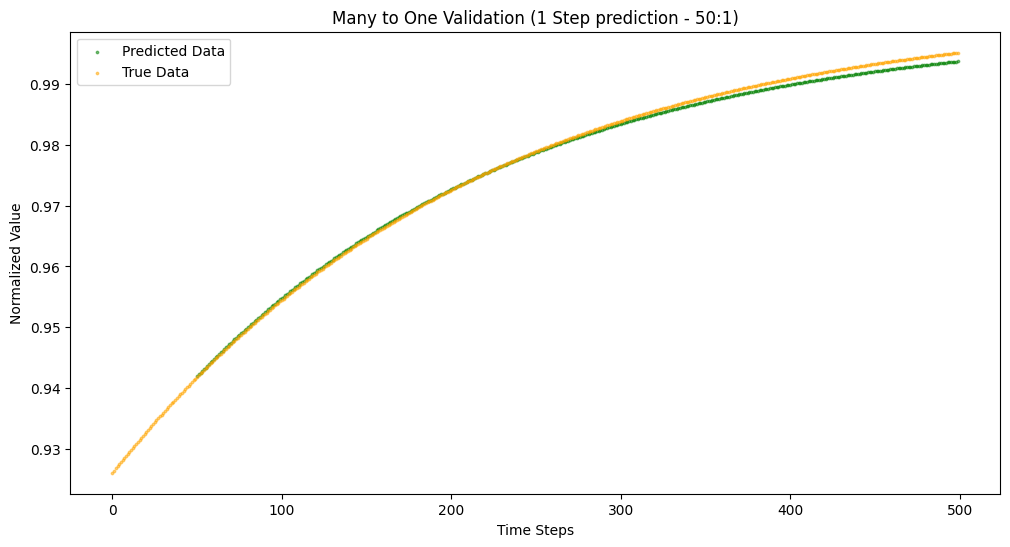

In [235]:
# Plot val_predictions vs val targets

plt.figure(figsize=(12, 6))
plt.scatter(range(50, len(val_data)), val_predictions, label="Predicted Data", color="green", s=3, alpha=0.5)
plt.scatter(range(len(val_data)), val_data, label="True Data", color="orange", s=3, alpha=0.5)
plt.xlabel("Time Steps")
plt.ylabel("Normalized Value")
plt.title(f"Many to One Validation ({1} Step prediction - 50:1)")
plt.legend()
plt.show()



# Validate "soft" many to many

In [232]:
num_predictions = 250
all_predictions = []
all_targets = []

for idx in range(len(val_dataset) - num_predictions):
    x, _ = val_dataset[idx]
    x = x.unsqueeze(0).to(device)

    predictions = []
    for _ in range(num_predictions):
        prediction = model(x)
        predictions.append(prediction.item())

        # auto regressive step (add prediction to the end of the sequence)
        x = torch.cat((x[:, 1:], prediction.unsqueeze(0)), dim=1)
    
    true_targets = val_dataset.data[idx + seq_len:idx + seq_len + num_predictions]

    all_predictions.extend(predictions)
    all_targets.append(true_targets.tolist())

all_targets_ = [t for sublist in all_targets for t in sublist]


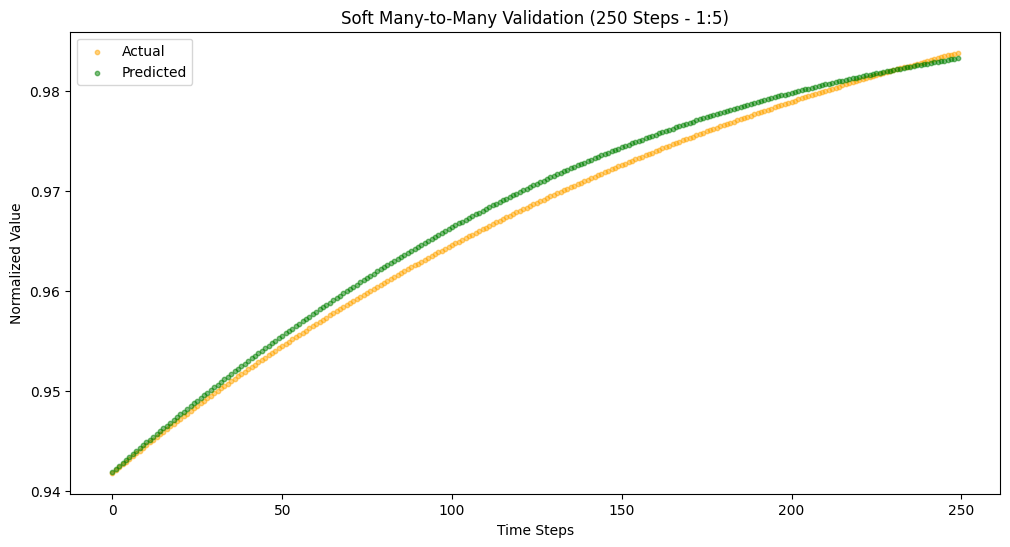

In [234]:
# Plot single sequence 
plt.figure(figsize=(12, 6))
plt.scatter(range(len(all_targets_[:250])), all_targets_[:250], label="Actual", color="orange", marker="o",s=10, alpha=0.5)
plt.scatter(range(len(all_predictions[:250])), all_predictions[:250], label="Predicted", color="green", marker="o", s=10, alpha=0.5)
plt.xlabel("Time Steps")
plt.ylabel("Normalized Value")
plt.title(f"Soft Many-to-Many Validation ({num_predictions} Steps - 1:5)")
plt.legend()
plt.show()


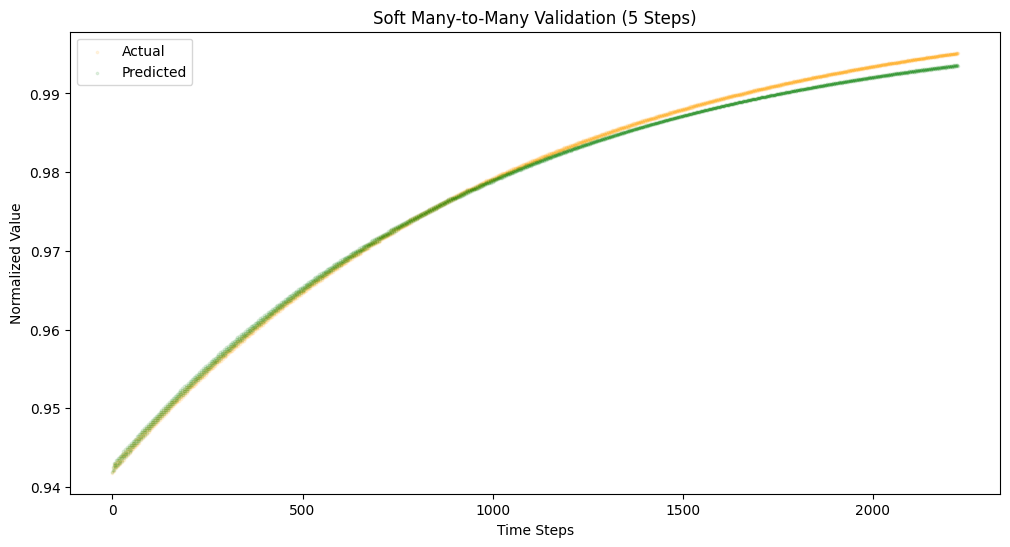

In [213]:
plt.figure(figsize=(12, 6))
plt.scatter(range(len(all_targets_)), all_targets_, label="Actual", color="orange", marker="o",s=3, alpha=0.1)
plt.scatter(range(len(all_predictions)), all_predictions, label="Predicted", color="green", marker="o", s=3, alpha=0.1)
plt.xlabel("Time Steps")
plt.ylabel("Normalized Value")
plt.title(f"Soft Many-to-Many Validation ({num_predictions} Steps)")
plt.legend()
plt.show()

# Test loop


Test Loss: 0.000000


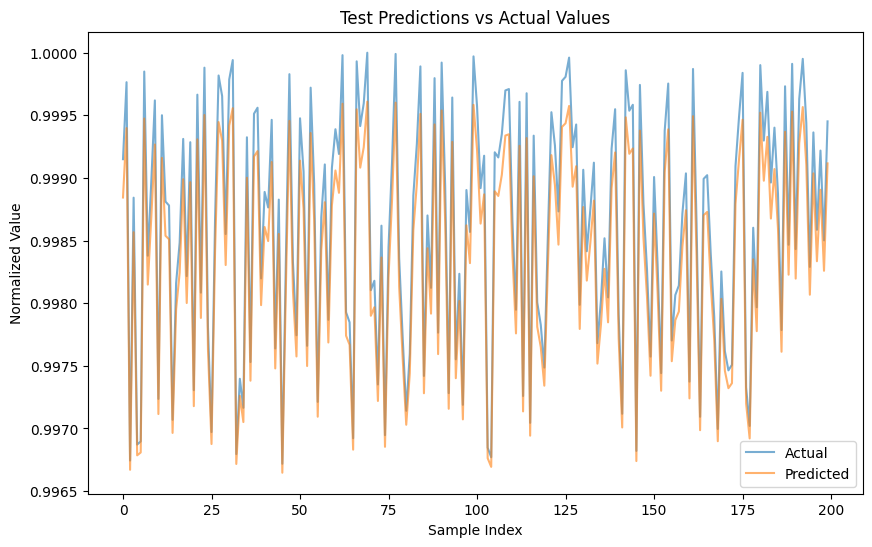

In [115]:
model.eval()
test_loss = 0.0
test_predictions = []
test_targets = []

with torch.no_grad():
    for x_batch_test, y_batch_test in test_dataloader:
        x_batch_test, y_batch_test = x_batch_test.to(device), y_batch_test.to(device)
        predictions = model(x_batch_test)
        test_loss += criterion(predictions, y_batch_test).item()
        test_predictions.extend(predictions.cpu().numpy())
        test_targets.extend(y_batch_test.cpu().numpy())

test_loss /= len(test_dataloader)
print(f"Test Loss: {test_loss:.6f}")

# Visualization
plt.figure(figsize=(10, 6))
plt.plot(test_targets, label="Actual", alpha=0.6)
plt.plot(test_predictions, label="Predicted", alpha=0.6)
plt.xlabel("Sample Index")
plt.ylabel("Normalized Value")
plt.legend()
plt.title("Test Predictions vs Actual Values")
plt.show()
